In [3]:
import imports as ii
import functions as f
import preprocessing as pp
import neuralnetworks as nn 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import gc
gc.collect()

50

In [4]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"
train = f.readJson(PATH["music_reviews_train"])
test = f.readJson(PATH["music_reviews_dev"])

Number of data:  100000
Number of data:  10000


In [28]:
X_train, y_train, train_idx, train_missing_idx = f.json_divide(train)
X_test, y_test, test_idx, test_missing_idx = f.json_divide(test)

# convert labels
sent_dict = {"positive": 1, "negative": 0}
y_train = pp.sentiment_converter(y_train, sent_dict)
y_test = pp.sentiment_converter(y_test, sent_dict)

In [29]:
# hack
end = 5000
start = 100
X_train = X_train[start:end+start]
y_train = y_train[start:end+start]
X_test = X_test[start:end+start]
y_test = y_test[start:end+start]

0.5966666666666667


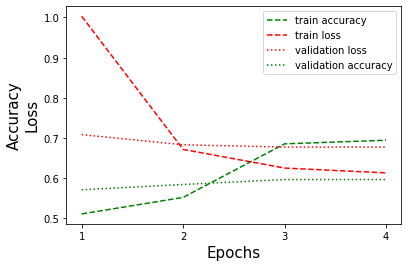

In [87]:
# accuracy score
result = ii.np.round(model.predict(X_test)) # use model from the previous step
print(i.accuracy_score(y_test, result))
# plotting 
f.plot_model_history(history)

# POS-tagger

In [ ]:
# https://www.nltk.org/api/nltk.tag.html
from nltk import pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')

#only works for english
def pos_tag_stringlist(strlist, shouldTokenize):
    pos_tagged_strlist = []
    if shouldTokenize: 
        for str in strlist: pos_tagged_strlist.append(pos_tag(word_tokenize(str)))
    else: 
        for str in strlist: pos_tagged_strlist.append(pos_tag(str))
    return pos_tagged_strlist

# Grid search

In [15]:
def grid_search(train_list, test_list, y_train, y_test):
    simp_contr = [0, 1]
    gram_cor = [0, 1]
    simp_neg = [0, 1]
    lemma = [0, 1]
    rem_stop = [0, 1]
    basic_preprocessing = 1
    list_of_data = []
    for z in simp_contr:
        for x in gram_cor:
            for c in simp_neg:
                for v in lemma:
                    for b in rem_stop:
                        train = train_list
                        test = test_list
                        if z == 1: # contractions
                            train = f.simplify_contraction(train)
                            test = f.simplify_contraction(test)
                        if basic_preprocessing == 1: # basic preprocessing
                            train = pp.basic_preprocess(train)
                            test = pp.basic_preprocess(test)
                        if x == 1: # grammar correction 
                            train = pp.grammar_corrector(train)
                            test = pp.grammar_corrector(test)
                        if c == 1: # Simnplyfy Negotiation 
                            train = f.simplify_negation(train)
                            test = f.simplify_negation(test)
                        if v == 1: # Lemmatize 
                            train = pp.lemmatize_sentencelist(train)
                            test = pp.lemmatize_sentencelist(test)
                        if b == 1: # Remove stop words
                            train = pp.remove_stop_words(train)
                            test = pp.remove_stop_words(test)

                        list_of_data.append([[z, basic_preprocessing, x, c, v, b], train, test]) #
    return list_of_data, y_train, y_test

# Below line is running for a while

In [18]:
data_sets, y_train, y_test = grid_search(X_train, X_test, y_train, y_test)

In [21]:
### INIT RESULTS
results, time = f.init_log_for_training()
# Init past results, read in only the oldest file

for data_set in data_sets:
    # Tokenizer
    labels = data_set[0]
    # check whenever combination is already checked. Working only with RNN!:

    tokenizer = pp.tokenizer_init(data_set[1], data_set[2])
    Train = tokenizer.texts_to_sequences(data_set[1])
    Test = tokenizer.texts_to_sequences(data_set[2])
        # Sequencer 
    X_train_p = pp.sequence_pad(Train) # there are several attributes which can be defined, basic = first 50 words 
    X_test_p = pp.sequence_pad(Test)
        
        # TRAIN
    #print("shapes: ", X_train_p.shape, X_test_p.shape)
    history, model = nn.RNN_train(X_train_p, y_train, X_test_p, y_test, tokenizer)
     ### LOGGING INIT - RNN
    # GET the index of the highest test ACCURACY where the RNN model stopped to TRAIN
    max_value = max(history.history['val_accuracy'])
    max_index = history.history['val_accuracy'].index(max_value)
    # append
    
    new_row = {'Running ID':time, 
           "Model Name":"RNN", 
          "Expand Contractions":labels[0],
          "Basic Preprocessing":labels[1],
          "Grammar Correction":labels[2],
           "Simplify Negotiations": labels[3],
          "Lemmatize": labels[4],
          "Remove Stop Words": labels[5],
          "No. of Sentences": len(data_set[1]),
          "Train Accuracy STOP": history.history['accuracy'][max_index],
          "Test Accuracy STOP": history.history['val_accuracy'][max_index],
          "Train Loss STOP": history.history['loss'][max_index],
          "Test Loss STOP": history.history['val_loss'][max_index]}
    
    results = results.append(new_row, ignore_index=True)
    # maybe we dont need it in every round but how knows
    try:
        results.to_csv("results/results_"+time+".csv")
    except: 
        continue
    f.plot_model_history(history)    
    # CLEAN
    del labels
    del tokenizer
    del Train
    del Test
    del X_train_p
    del X_test_p
    del history
    del model 
    
# save results again
print("Combinations were checked")
results.to_csv("results/results_"+time+".csv") 

Epoch 1/10
60/60 [==============================] - 8s 111ms/step - loss: 1.5828 - accuracy: 0.5970 - val_loss: 0.6787 - val_accuracy: 0.5880 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.7683
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 [==============================] - 6s 102ms/step - loss: 0.5142 - accuracy: 0.7683 - val_loss: 0.4495 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9220
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
60/60 [==============================] - 8s 128ms/step - loss: 0.2268 - accuracy: 0.9220 - val_loss: 0.5056 - val_accuracy: 0.8150 - lr: 2.0000e-04
Epoch 4/10
60/60 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9417
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
60/60 [==============================] - 

Epoch 9: early stopping
Epoch 1/10
60/60 [==============================] - 8s 116ms/step - loss: 1.1532 - accuracy: 0.6017 - val_loss: 0.6915 - val_accuracy: 0.5837 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.6983
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 [==============================] - 7s 110ms/step - loss: 0.5731 - accuracy: 0.6983 - val_loss: 0.6501 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8490
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
60/60 [==============================] - 7s 110ms/step - loss: 0.3511 - accuracy: 0.8490 - val_loss: 0.5343 - val_accuracy: 0.7980 - lr: 2.0000e-04
Epoch 4/10
60/60 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9270
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
60/60 [==========

60/60 [==============================] - 7s 118ms/step - loss: 0.1677 - accuracy: 0.9480 - val_loss: 0.4606 - val_accuracy: 0.8287 - lr: 3.2000e-07
Epoch 7: early stopping
Epoch 1/10
60/60 [==============================] - 9s 120ms/step - loss: 0.7279 - accuracy: 0.6170 - val_loss: 0.6877 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7197
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 [==============================] - 7s 111ms/step - loss: 0.5485 - accuracy: 0.7197 - val_loss: 0.6159 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9097
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
60/60 [==============================] - 7s 112ms/step - loss: 0.2461 - accuracy: 0.9097 - val_loss: 0.4719 - val_accuracy: 0.8260 - lr: 2.0000e-04
Epoch 4/10
60/60 [=====================

Epoch 1/10
60/60 [==============================] - 9s 122ms/step - loss: 0.7596 - accuracy: 0.6263 - val_loss: 0.6841 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7013
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 [==============================] - 7s 115ms/step - loss: 0.5680 - accuracy: 0.7013 - val_loss: 0.7243 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.9000
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
60/60 [==============================] - 7s 115ms/step - loss: 0.2832 - accuracy: 0.9000 - val_loss: 0.6115 - val_accuracy: 0.8260 - lr: 2.0000e-04
Epoch 4/10
60/60 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9327
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
60/60 [==============================] - 

Epoch 4/10
60/60 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9197
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
60/60 [==============================] - 7s 109ms/step - loss: 0.2417 - accuracy: 0.9197 - val_loss: 0.5417 - val_accuracy: 0.8100 - lr: 4.0000e-05
Epoch 5/10
60/60 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9277
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
60/60 [==============================] - 7s 109ms/step - loss: 0.2152 - accuracy: 0.9277 - val_loss: 0.5416 - val_accuracy: 0.8127 - lr: 8.0000e-06
Epoch 6/10
60/60 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9277
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
60/60 [==============================] - 6s 108ms/step - loss: 0.2110 - accuracy: 0.9277 - val_loss: 0.5445 - val_accuracy: 0.8130 - lr: 1.6000e-06
Epoch 7/10
60/60 [===========================

60/60 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.7750
Epoch 7: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
60/60 [==============================] - 8s 132ms/step - loss: 0.5073 - accuracy: 0.7750 - val_loss: 0.6800 - val_accuracy: 0.6283 - lr: 3.2000e-07
Epoch 8/10
60/60 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.7750
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
60/60 [==============================] - 8s 127ms/step - loss: 0.5073 - accuracy: 0.7750 - val_loss: 0.6800 - val_accuracy: 0.6283 - lr: 6.4000e-08
Epoch 9/10
60/60 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.7750
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.5600002118153498e-09.
60/60 [==============================] - 8s 129ms/step - loss: 0.5072 - accuracy: 0.7750 - val_loss: 0.6800 - val_accuracy: 0.6283 - lr: 1.2800e-08
Epoch 9: early stopping
Epoch 1/10
60/60 [=============

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001F78D11F0D0>
Traceback (most recent call last):
  File "c:\users\music\appdata\local\programs\python\python39\lib\weakref.py", line 368, in remove
    self = selfref()
KeyboardInterrupt: 


Epoch 1/10
42/60 [====================>.........] - ETA: 1s - loss: 0.9479 - accuracy: 0.5905

KeyboardInterrupt: 

# Leave it in here for experimenting purpose: 

In [248]:
'''### INIT RESULTS
results, time = f.init_log_for_training()
for c in range(2):
    # Tokenizer
    labels = data_sets[c][0]
    print("##### Combination\n: ", data_sets[c][0])
    tokenizer = pp.tokenizer_init(data_sets[c][1], data_sets[c][2])
    Train = tokenizer.texts_to_sequences(data_sets[c][1])
    Test = tokenizer.texts_to_sequences(data_sets[c][2])
        # Sequencer 
    X_train_p = pp.sequence_pad(Train) # there are several attributes which can be defined, basic = first 50 words 
    X_test_p = pp.sequence_pad(Test)
        
    # TRAIN RNN
    history, model = nn.RNN_train(X_train_p, y_train, X_test_p, y_test, tokenizer)

    ### LOGGING INIT - RNN
    # GET the index of the highest test ACCURACY where the RNN model stopped to TRAIN
    max_value = max(history.history['val_accuracy'])
    max_index = history.history['val_accuracy'].index(max_value)
    # append
    
    new_row = {'Running ID':save_time, 
           "Model Name":"RNN", 
          "Expand Contractions":labels[0],
          "Basic Preprocessing":labels[1],
          "Grammar Correction":labels[2],
           "Simplify Negotiations": labels[3],
          "Lemmatize": labels[4],
          "Remove Stop Words": labels[5],
          "No. of Sentences": len(data_sets[c][1]),
          "Train Accuracy STOP": history.history['accuracy'][max_index],
          "Test Accuracy STOP": history.history['val_accuracy'][max_index],
          "Train Loss STOP": history.history['loss'][max_index],
          "Test Loss STOP": history.history['val_loss'][max_index]}
    
    results = results.append(new_row, ignore_index=True)
    
# save results
results.to_csv("results/results_"+time+".csv") '''

##### Combination
:  [0, 1, 0, 0, 0, 0]
Epoch 1/10
20/20 [==============================] - 5s 175ms/step - loss: 1.2002 - accuracy: 0.5320 - val_loss: 0.6855 - val_accuracy: 0.5870 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.5910
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 3s 149ms/step - loss: 0.6491 - accuracy: 0.5910 - val_loss: 0.6657 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.7610
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20/20 [==============================] - 3s 149ms/step - loss: 0.6129 - accuracy: 0.7610 - val_loss: 0.6637 - val_accuracy: 0.6260 - lr: 2.0000e-04
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7640
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
2